<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/EE_%2B_RF_%2B_MLP_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Load and Select Columns

In [3]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

Cell 3: Data Preprocessing

In [4]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý:
      price vehicleType   powerPS    model  kilometer  monthOfRegistration  \
0  0.010168     unknown  0.203390     golf   1.000000             0.454545   
1  0.499863       coupe  0.491525  unknown   0.827586             0.363636   
2  0.266282         suv  0.400000    grand   0.827586             0.636364   
3  0.038197  kleinwagen  0.101695     golf   1.000000             0.454545   
4  0.095905  kleinwagen  0.081356    fabia   0.586207             0.545455   

  fuelType       brand  adYear   car_age  powerPS_per_km  age_km_interaction  \
0   benzin  volkswagen     1.0  0.641026        0.000199            0.406100   
1   die

Cell 4: Train-Test Split

In [5]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Encode Categorical Variables for Embedding (MLP)

In [6]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.


Cell 6: Prepare Data for Random Forest

In [7]:
X_train_rf = X_train_new.copy()
X_val_rf = X_val.copy()
X_test_rf = X_test.copy()

# One-hot encode categorical variables
cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
X_train_rf = pd.get_dummies(X_train_rf, columns=cat_cols)
X_val_rf = pd.get_dummies(X_val_rf, columns=cat_cols)
X_test_rf = pd.get_dummies(X_test_rf, columns=cat_cols)

# Align columns across train, validation, and test sets
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)
X_val_rf, X_test_rf = X_val_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

print(f"Random Forest training data shape: {X_train_rf.shape}")
print(f"Random Forest validation data shape: {X_val_rf.shape}")
print(f"Random Forest test data shape: {X_test_rf.shape}")

Random Forest training data shape: (230880, 318)
Random Forest validation data shape: (57720, 318)
Random Forest test data shape: (72150, 318)


Cell 7: Train Random Forest and Generate Predictions

In [8]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train_new)

# Generate RF predictions
rf_train_preds = rf.predict(X_train_rf).astype(np.float32)
rf_val_preds = rf.predict(X_val_rf).astype(np.float32)
rf_test_preds = rf.predict(X_test_rf).astype(np.float32)

Cell 8: Define and Train MLP Model (Standalone)

In [10]:
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))  # Fixed typo here

input_brand = Input(shape=(1,), name='input_brand_mlp')
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model_mlp')
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType_mlp')
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType_mlp')
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),), name='input_numeric_mlp')
emb_numeric = input_numeric

input_data_mlp = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data_mlp = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

model_data_mlp = Concatenate()(emb_data_mlp)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data_mlp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs_mlp = Dense(1, activation='sigmoid')(x)

mlp = Model(inputs=input_data_mlp, outputs=outputs_mlp, name='MLP')
mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history_mlp = mlp.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)



Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.3800 - mae: 0.0711 - val_loss: 0.0397 - val_mae: 0.1134 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0096 - mae: 0.0505 - val_loss: 0.0094 - val_mae: 0.0471 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0094 - mae: 0.0505 - val_loss: 0.0128 - val_mae: 0.0662 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0092 - mae: 0.0515 - val_loss: 0.0084 - val_mae: 0.0463 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0090 - mae: 0.0510 - val_loss: 0.0105 - val_mae: 0.0551 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0089 - mae: 0.0504 - val_loss: 0.0081 - val_mae: 0.0506 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0085 - mae: 0.0497 - val_loss: 0.0088 - val_mae: 0.0469 - learning_r

Cell 9: Define and Train EE+RF+MLP Model

Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.4051 - mae: 0.0640 - val_loss: 0.0383 - val_mae: 0.1547 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0054 - mae: 0.0383 - val_loss: 0.0139 - val_mae: 0.0713 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0040 - mae: 0.0348 - val_loss: 0.0107 - val_mae: 0.0597 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0038 - mae: 0.0342 - val_loss: 0.0064 - val_mae: 0.0428 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0063 - val_mae: 0.0432 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0039 - mae: 0.0346 - val_loss: 0.0063 - val_mae: 0.0402 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0038 - mae: 0.0344 - val_loss: 0.0117 - val_mae: 0.0709 - learning_ra

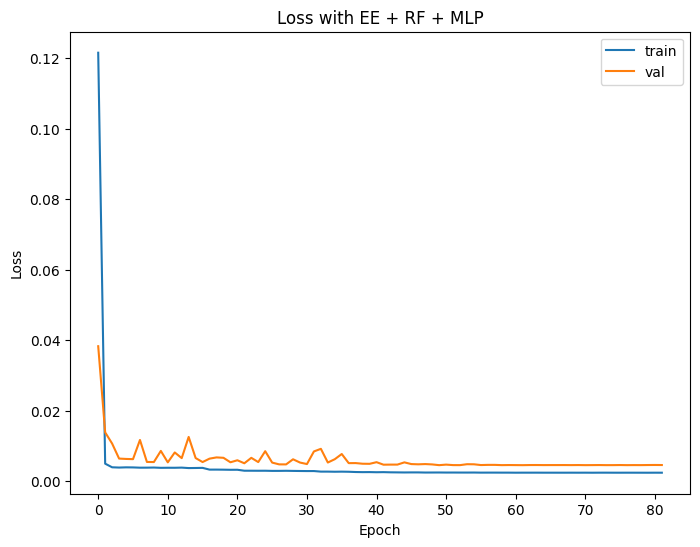

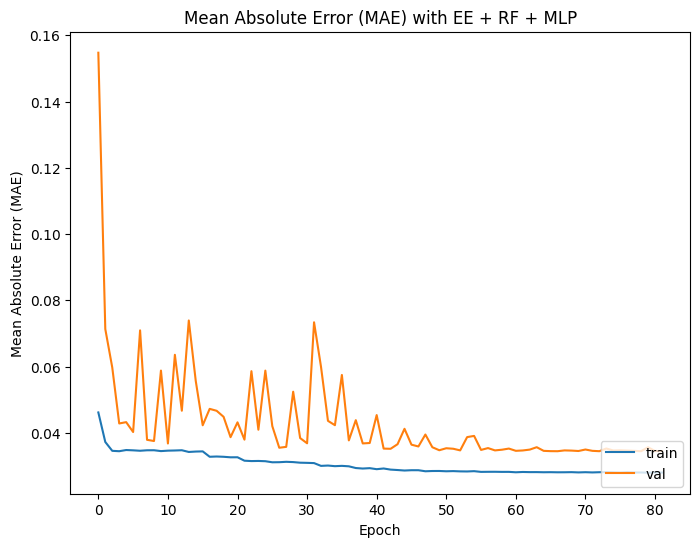

In [12]:
input_brand = Input(shape=(1,), name='input_brand')
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model')
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType')
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType')
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),), name='input_numeric')
emb_numeric = input_numeric

input_rf = Input(shape=(1,), name='input_rf')
input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric, input_rf]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric, input_rf]

model_data = Concatenate()(emb_data)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)

ee_rf_mlp = Model(inputs=input_data, outputs=outputs, name='EE_RF_MLP')
ee_rf_mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

# Update input lists with RF predictions
input_list_train_new_rf = input_list_train_new + [rf_train_preds]
input_list_val_rf = input_list_val + [rf_val_preds]
input_list_test_rf = input_list_test + [rf_test_preds]

history_ee_rf_mlp = ee_rf_mlp.fit(
    input_list_train_new_rf,
    y_train_new,
    validation_data=(input_list_val_rf, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Plot training history for EE+RF+MLP
plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['loss'], label='Training Loss')
plt.plot(history_ee_rf_mlp.history['val_loss'], label='Validation Loss')
plt.title('Loss with EE + RF + MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['mae'], label='Training MAE')
plt.plot(history_ee_rf_mlp.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with EE + RF + MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 10: Evaluation

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Evaluation Metrics:
              MLP    EE_RF_MLP
MSE     6802322.0    5388758.0
RMSE  2608.126147  2321.369854
R2        0.85438     0.884641
MAPE    44.280552    36.689846


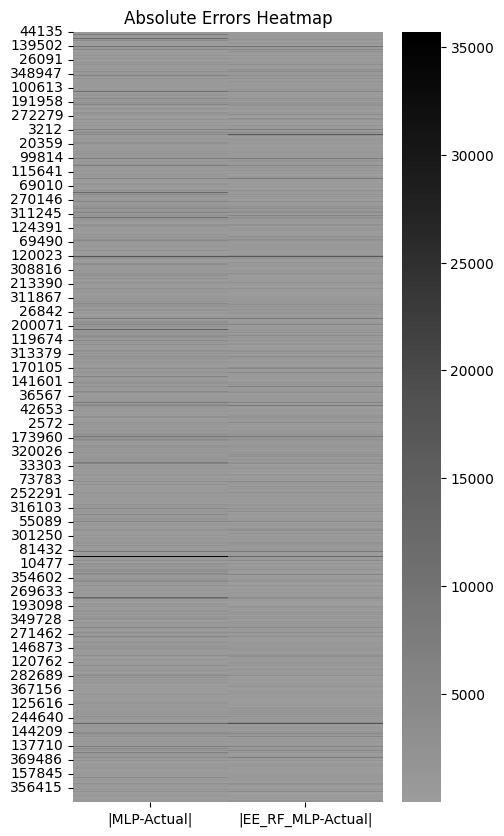

In [13]:
# # Predictions
# y_test_predict_mlp = mlp.predict(input_list_test).flatten()
# y_test_predict_rf = rf.predict(X_test_rf)
# y_test_predict_ee_rf_mlp = ee_rf_mlp.predict(input_list_test_rf).flatten()

# # Inverse transform predictions and actual values
# y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp.reshape(-1, 1)).flatten()
# y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()
# y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(y_test_predict_ee_rf_mlp.reshape(-1, 1)).flatten()
# y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# # Create results DataFrame
# result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'EE_RF_MLP', 'Actual'])
# result_df['Actual'] = y_test_original
# # result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
# # result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
# result_df['MLP'] = y_test_predict_mlp
# # result_df['RF'] = y_test_predict_rf
# result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# # Define metric calculation function
# def calculate_metrics(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100  # Avoid division by zero
#     return mse, rmse, r2, mape

# # Calculate metrics for all models
# metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'],
#                         columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'EE_RF_MLP'])

# for model in metric_df.columns:
#     mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df[model])
#     metric_df.at['MSE', model] = mse
#     metric_df.at['RMSE', model] = rmse
#     metric_df.at['R2', model] = r2
#     metric_df.at['MAPE', model] = mape

# print("Evaluation Metrics:")
# print(metric_df)

# # Heatmap of absolute errors
# for m in metric_df.columns:
#     result_df[f'|{m}-Actual|'] = np.abs(result_df[m] - result_df['Actual'])

# table = result_df[[f'|{m}-Actual|' for m in metric_df.columns]]
# plt.figure(figsize=(5, 10))
# sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
# plt.title('Absolute Errors Heatmap')
# plt.show()

# Predictions
y_test_predict_mlp = mlp.predict(input_list_test).flatten()
y_test_predict_rf = rf.predict(X_test_rf)
y_test_predict_ee_rf_mlp = ee_rf_mlp.predict(input_list_test_rf).flatten()

# Inverse transform predictions and actual values
y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp.reshape(-1, 1)).flatten()
y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(y_test_predict_ee_rf_mlp.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['MLP', 'EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['MLP'] = y_test_predict_mlp
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100  # Avoid division by zero
    return mse, rmse, r2, mape

# Calculate metrics for available models
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=result_df.columns.drop('Actual'))

for model in metric_df.columns:
    if result_df[model].isnull().any():  # Skip models with NaN values
        continue
    mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df[model])
    metric_df.at['MSE', model] = mse
    metric_df.at['RMSE', model] = rmse
    metric_df.at['R2', model] = r2
    metric_df.at['MAPE', model] = mape

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of absolute errors
for m in metric_df.columns:
    result_df[f'|{m}-Actual|'] = np.abs(result_df[m] - result_df['Actual'])

table = result_df[[f'|{m}-Actual|' for m in metric_df.columns]]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()


Cell 11: Scatter Plots for Model Predictions

7215/7215 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


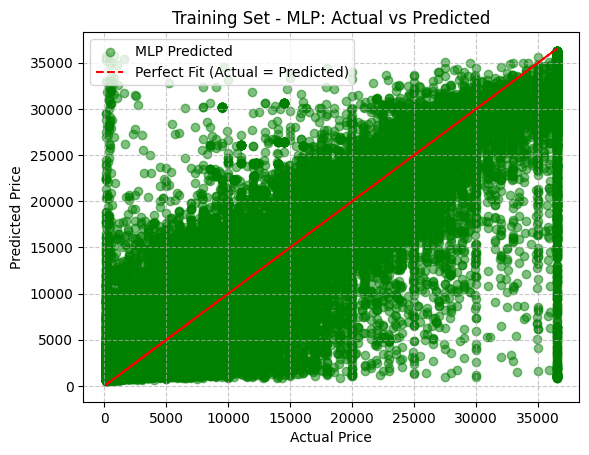

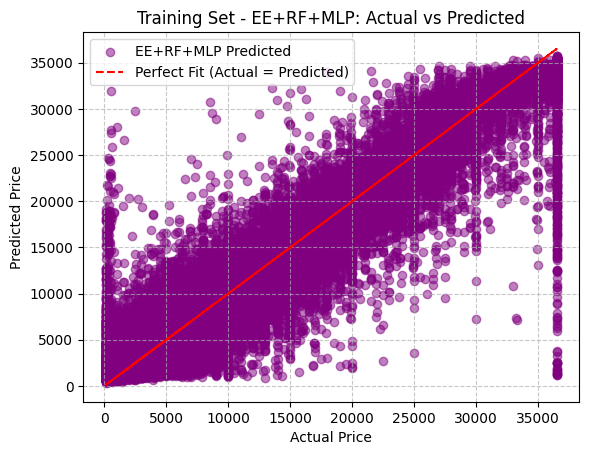

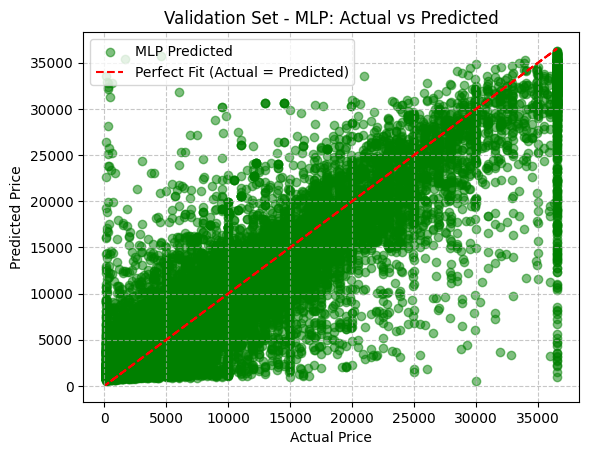

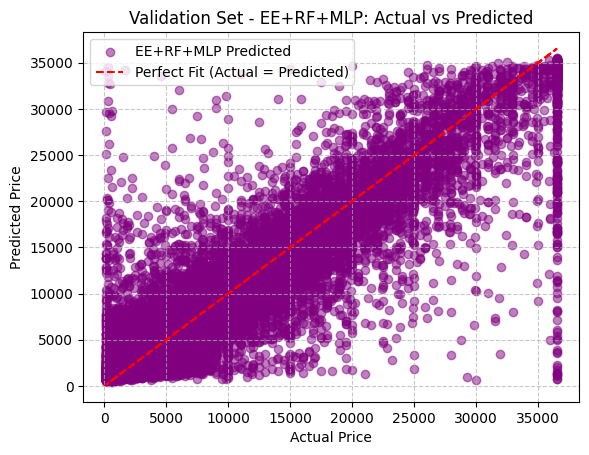

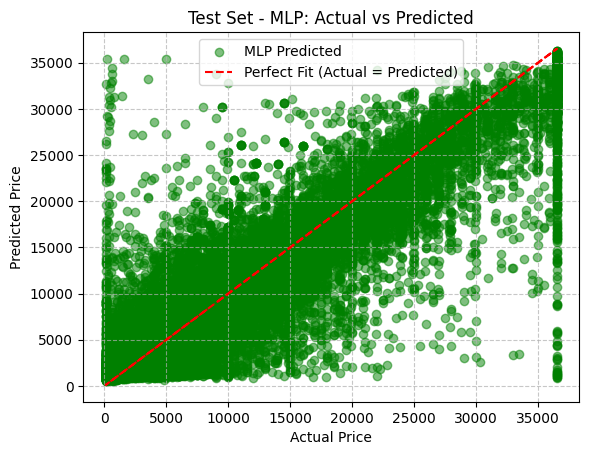

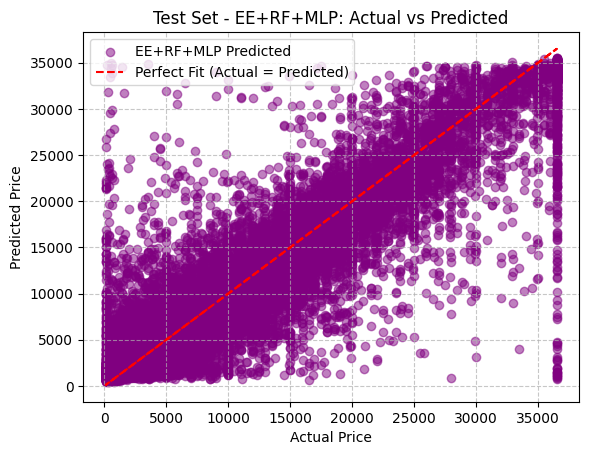

In [18]:
# import matplotlib.pyplot as plt

# # Function to create scatter plot
# def scatter_plot(actual, predicted, title, color='blue', label='Predicted'):
#     plt.scatter(actual, predicted, color=color, alpha=0.5, label=label)
#     plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Fit (Actual = Predicted)')
#     plt.title(title)
#     plt.xlabel('Actual Price')
#     plt.ylabel('Predicted Price')
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.show()

# # Predictions on training set (recompute for consistency)
# y_train_pred_mlp = mlp.predict(input_list_train_new).flatten()
# y_train_pred_rf = rf.predict(X_train_rf)
# y_train_pred_ee_rf_mlp = ee_rf_mlp.predict(input_list_train_new_rf).flatten()

# # Predictions on validation set (recompute for consistency)
# y_val_pred_mlp = mlp.predict(input_list_val).flatten()
# y_val_pred_rf = rf.predict(X_val_rf)
# y_val_pred_ee_rf_mlp = ee_rf_mlp.predict(input_list_val_rf).flatten()

# # Predictions on test set (already computed in Cell 10)
# y_test_pred_mlp = result_df['MLP']
# y_test_pred_rf = result_df['RF']
# y_test_pred_ee_rf_mlp = result_df['EE_RF_MLP']

# # Inverse transform training and validation predictions to original scale
# y_train_pred_mlp = price_scaler.inverse_transform(y_train_pred_mlp.reshape(-1, 1)).flatten()
# y_train_pred_rf = price_scaler.inverse_transform(y_train_pred_rf.reshape(-1, 1)).flatten()
# y_train_pred_ee_rf_mlp = price_scaler.inverse_transform(y_train_pred_ee_rf_mlp.reshape(-1, 1)).flatten()

# y_val_pred_mlp = price_scaler.inverse_transform(y_val_pred_mlp.reshape(-1, 1)).flatten()
# y_val_pred_rf = price_scaler.inverse_transform(y_val_pred_rf.reshape(-1, 1)).flatten()
# y_val_pred_ee_rf_mlp = price_scaler.inverse_transform(y_val_pred_ee_rf_mlp.reshape(-1, 1)).flatten()

# y_train_original = price_scaler.inverse_transform(y_train_new.reshape(-1, 1)).flatten()
# y_val_original = price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
# y_test_original = result_df['Actual']

# # Create scatter plots for training set
# scatter_plot(y_train_original, y_train_pred_mlp, 'Training Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
# scatter_plot(y_train_original, y_train_pred_rf, 'Training Set - RF: Actual vs Predicted', color='orange', label='RF Predicted')
# scatter_plot(y_train_original, y_train_pred_ee_rf_mlp, 'Training Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

# # Create scatter plots for validation set
# scatter_plot(y_val_original, y_val_pred_mlp, 'Validation Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
# scatter_plot(y_val_original, y_val_pred_rf, 'Validation Set - RF: Actual vs Predicted', color='orange', label='RF Predicted')
# scatter_plot(y_val_original, y_val_pred_ee_rf_mlp, 'Validation Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

# # Create scatter plots for test set
# scatter_plot(y_test_original, y_test_pred_mlp, 'Test Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
# scatter_plot(y_test_original, y_test_pred_rf, 'Test Set - RF: Actual vs Predicted', color='orange', label='RF Predicted')
# scatter_plot(y_test_original, y_test_pred_ee_rf_mlp, 'Test Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

import matplotlib.pyplot as plt

# Function to create scatter plot
def scatter_plot(actual, predicted, title, color='blue', label='Predicted'):
    plt.scatter(actual, predicted, color=color, alpha=0.5, label=label)
    plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Fit (Actual = Predicted)')
    plt.title(title)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Predictions on training set
y_train_pred_mlp = mlp.predict(input_list_train_new).flatten()
y_train_pred_ee_rf_mlp = ee_rf_mlp.predict(input_list_train_new_rf).flatten()

# Predictions on validation set
y_val_pred_mlp = mlp.predict(input_list_val).flatten()
y_val_pred_ee_rf_mlp = ee_rf_mlp.predict(input_list_val_rf).flatten()

# Predictions on test set from result_df
y_test_pred_mlp = result_df['MLP']
y_test_pred_ee_rf_mlp = result_df['EE_RF_MLP']

# Inverse transform training and validation predictions to original scale
y_train_pred_mlp = price_scaler.inverse_transform(y_train_pred_mlp.reshape(-1, 1)).flatten()
y_train_pred_ee_rf_mlp = price_scaler.inverse_transform(y_train_pred_ee_rf_mlp.reshape(-1, 1)).flatten()

y_val_pred_mlp = price_scaler.inverse_transform(y_val_pred_mlp.reshape(-1, 1)).flatten()
y_val_pred_ee_rf_mlp = price_scaler.inverse_transform(y_val_pred_ee_rf_mlp.reshape(-1, 1)).flatten()

y_train_original = price_scaler.inverse_transform(y_train_new.reshape(-1, 1)).flatten()
y_val_original = price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_original = result_df['Actual']

# Create scatter plots for training set
scatter_plot(y_train_original, y_train_pred_mlp, 'Training Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
scatter_plot(y_train_original, y_train_pred_ee_rf_mlp, 'Training Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

# Create scatter plots for validation set
scatter_plot(y_val_original, y_val_pred_mlp, 'Validation Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
scatter_plot(y_val_original, y_val_pred_ee_rf_mlp, 'Validation Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

# Create scatter plots for test set
scatter_plot(y_test_original, y_test_pred_mlp, 'Test Set - MLP: Actual vs Predicted', color='green', label='MLP Predicted')
scatter_plot(y_test_original, y_test_pred_ee_rf_mlp, 'Test Set - EE+RF+MLP: Actual vs Predicted', color='purple', label='EE+RF+MLP Predicted')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━

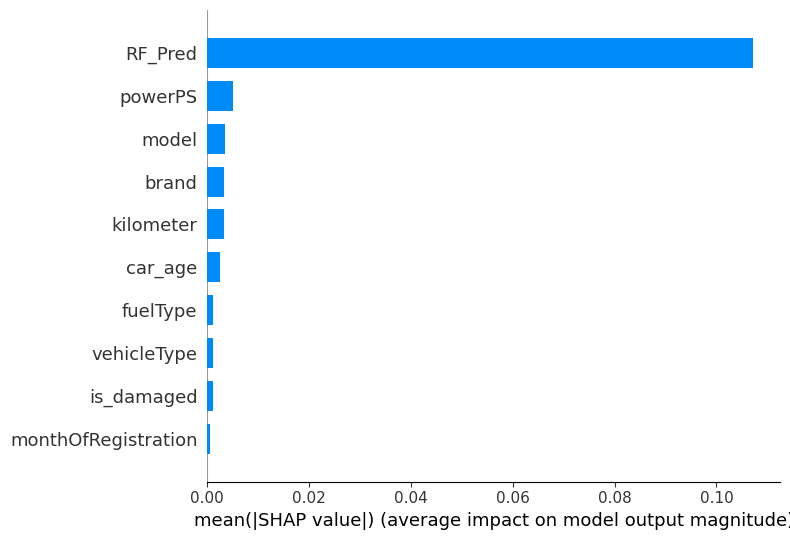

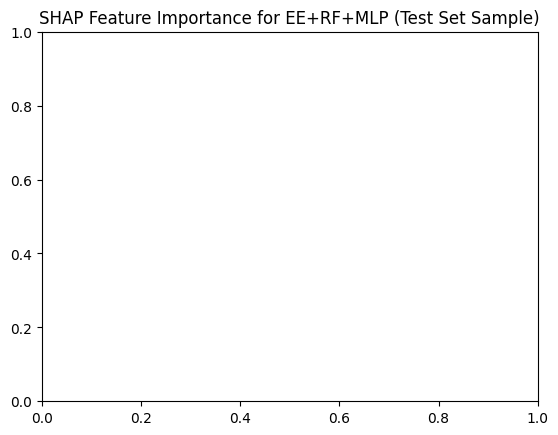

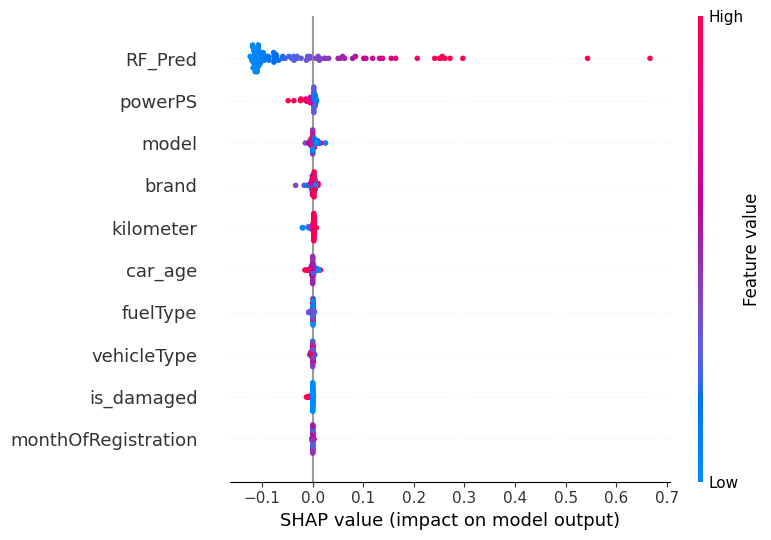

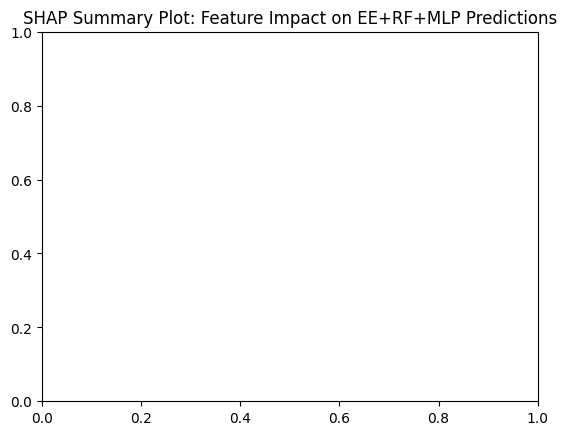

<Figure size 1000x600 with 0 Axes>

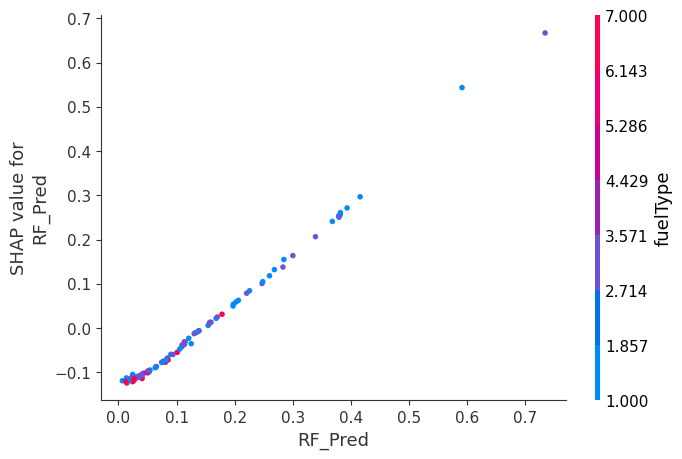

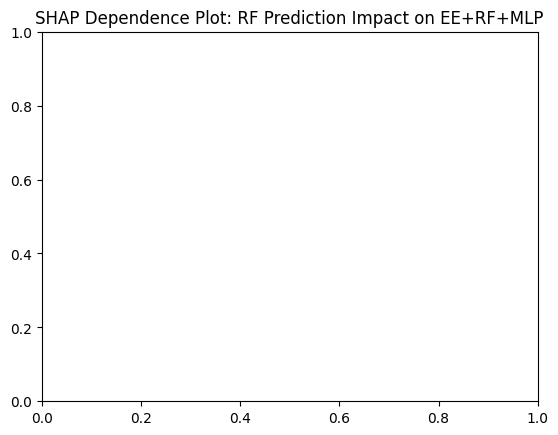

SHAP Analysis Summary for EE+RF+MLP:
Expected Value (Baseline Prediction): 0.14
Average Absolute SHAP Value (Feature Impact): 0.0081
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Mean Test Prediction (Full Set): 0.15


In [21]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt

# # Use a smaller subset of the test set for SHAP computation (to reduce computation time)
# X_test_rf_sample = X_test_rf.sample(1000, random_state=42)  # Sample 1000 rows
# rf_test_preds_sample = rf.predict(X_test_rf_sample)

# # Create a SHAP explainer for the Random Forest model
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test_rf_sample)

# # 1. Summary Plot (Feature Importance)
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values, X_test_rf_sample, plot_type="bar", max_display=10)
# plt.title("SHAP Feature Importance for Random Forest (Test Set Sample)")
# plt.show()

# # 2. Detailed Summary Plot (Feature Impact Distribution)
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values, X_test_rf_sample, max_display=10)
# plt.title("SHAP Summary Plot: Feature Impact on RF Predictions (Test Set Sample)")
# plt.show()

# # 3. Dependence Plot for the Top Feature
# top_feature = feature_importance['Feature'].iloc[0]  # From Cell 7 output
# plt.figure(figsize=(10, 6))
# shap.dependence_plot(
#     ind=top_feature,
#     shap_values=shap_values,
#     features=X_test_rf_sample,
#     feature_names=X_test_rf_sample.columns.tolist()
# )
# plt.title(f"SHAP Dependence Plot: {top_feature} Impact on RF Predictions")
# plt.show()

# # 4. Force Plot for a Single Prediction (example: first sample)
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[0],
#     X_test_rf_sample.iloc[0],
#     matplotlib=True,
#     show=False
# )
# plt.title("SHAP Force Plot: Explanation for a Single RF Prediction")
# plt.show()

# # Print summary of SHAP values for interpretation
# print("SHAP Analysis Summary:")
# print(f"Expected Value (Baseline Prediction): {explainer.expected_value:.2f}")
# print(f"Average Absolute SHAP Value (Feature Impact): {np.mean(np.abs(shap_values)):.4f}")

import shap
import numpy as np
import matplotlib.pyplot as plt

# Prepare a background dataset
background_sample = [x[:100] for x in input_list_train_new_rf]
background_sample_2d = [arr.reshape(-1, 1) if arr.ndim == 1 else arr for arr in background_sample]
background_data = np.hstack(background_sample_2d)

# Prepare test data
test_sample = [x[:100] for x in input_list_test_rf]
test_sample_2d = [arr.reshape(-1, 1) if arr.ndim == 1 else arr for arr in test_sample]
test_data = np.hstack(test_sample_2d)

# Define prediction function
def predict_fn(data):
    split_indices = [0] + [arr.shape[1] for arr in background_sample_2d[:-1]]
    split_indices = np.cumsum(split_indices)
    input_list = [data[:, split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
    input_list.append(data[:, split_indices[-1]:])
    return ee_rf_mlp.predict(input_list).flatten()

# Create SHAP explainer
explainer = shap.KernelExplainer(predict_fn, background_data)
shap_values = explainer.shap_values(test_data, nsamples=100)

# Feature names
feature_names = ['brand', 'model', 'vehicleType', 'fuelType'] + numeric_cols + ['RF_Pred']

# Summary plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, test_data, feature_names=feature_names, plot_type="bar", max_display=10)
plt.title("SHAP Feature Importance for EE+RF+MLP (Test Set Sample)")
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, test_data, feature_names=feature_names, max_display=10)
plt.title("SHAP Summary Plot: Feature Impact on EE+RF+MLP Predictions")
plt.show()

# Dependence plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind=len(feature_names)-1,
    shap_values=shap_values,
    features=test_data,
    feature_names=feature_names
)
plt.title("SHAP Dependence Plot: RF Prediction Impact on EE+RF+MLP")
plt.show()

# SHAP summary
print("SHAP Analysis Summary for EE+RF+MLP:")
print(f"Expected Value (Baseline Prediction): {explainer.expected_value:.2f}")
print(f"Average Absolute SHAP Value (Feature Impact): {np.mean(np.abs(shap_values)):.4f}")

# Validate with full test set mean
full_test_pred = ee_rf_mlp.predict(input_list_test_rf).mean()
print(f"Mean Test Prediction (Full Set): {full_test_pred:.2f}")